In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from scipy.stats import lognorm


import torch
import pyro

from pyro.infer import SVI, Trace_ELBO, Predictive

from jax import random
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, MCMC, NUTS
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoMultivariateNormal

from pyro.optim import Adam


def add_jittered_com(data, jitter=0.00):
    if "c_trust_jittered" not in data.columns:
        data["c_trust_jittered"] = data["c_trust"] + np.random.uniform(
            -jitter, jitter, len(data)
        )
    return data


In [2]:
impactDF_grid30_1 = pd.read_csv("../data/communicators/communicators_impact/resultsDF_grid30.csv", index_col=0)
impactDF_grid30_2 = pd.read_csv("../data/communicators/communicators_impact/resultsDF_grid30_2.csv", index_col=0)
impactDF_grid30 = pd.concat([impactDF_grid30_1, impactDF_grid30_2], axis=0)
impactDF_grid30 = impactDF_grid30[impactDF_grid30["time to first food"] < 48]


impactDF_grid30 = impactDF_grid30[impactDF_grid30["reward_patch_dim"].isin([1, 2, 4])]

impactDF_grid30["reward_patch_dim"] = impactDF_grid30["reward_patch_dim"].astype("category")

impactDF_grid30 = impactDF_grid30[impactDF_grid30["time to first food"] < 48]
impactDF_grid30 = add_jittered_com(impactDF_grid30, jitter=0.004)


impactDF_grid45 = pd.read_csv("../data/communicators/communicators_impact/resultsDF_grid45.csv", index_col=0)
print(impactDF_grid30.shape, impactDF_grid45.shape)

impactDF_grid45 = impactDF_grid45[impactDF_grid45["time to first food"] < 48]

impactDF_grid45["reward_patch_dim"] = impactDF_grid45["reward_patch_dim"].astype("category")
impactDF_grid45 = add_jittered_com(impactDF_grid45)
print(impactDF_grid30.shape, impactDF_grid45.shape)

(829, 8) (610, 7)
(829, 8) (593, 8)


In [3]:
fig_grid30 = px.scatter(
    impactDF_grid30,
    x="c_trust_jittered",
    y="time to first food",
    color="reward_patch_dim",
    template="plotly_dark",
    title="Trust vs time to first food (grid 30)",
    trendline="lowess",
    opacity=0.5,
)

fig_grid30.update_traces(marker={"size": 4})
fig_grid30.update_layout(
    width=800,
    height=800,
)


In [4]:
fig_grid45 = px.scatter(
    impactDF_grid45,
    x="c_trust_jittered",
    y="time to first food",
    color="reward_patch_dim",
    template="plotly_dark",
    title="Trust vs time to first food (grid 45)",
    trendline="lowess",
    opacity=0.5,
)

fig_grid45.update_traces(marker={"size": 4})
fig_grid45.update_layout(
    width=800,
    height=800,
)


In [5]:
# these should approximately be
# points of slight inflection int he corresponding smoothed diagrams
threshold_30 = 0.25
threshold_45 = 0.25

restriction30_low = (impactDF_grid30["c_trust"] >= 0.0) & (impactDF_grid30["c_trust"] <= threshold_30)
restriction30_high = impactDF_grid30["c_trust"] > threshold_30

impactDF_grid30_low = impactDF_grid30[restriction30_low].copy()
impactDF_grid30_high = impactDF_grid30[restriction30_high].copy()

restriction45_low = (impactDF_grid45["c_trust"] >= 0.0) & (impactDF_grid45["c_trust"] <= threshold_45)
restriction45_high = impactDF_grid45["c_trust"] > threshold_45

impactDF_grid45_low = impactDF_grid45[restriction45_low].copy()
impactDF_grid45_high = impactDF_grid45[restriction45_high].copy()

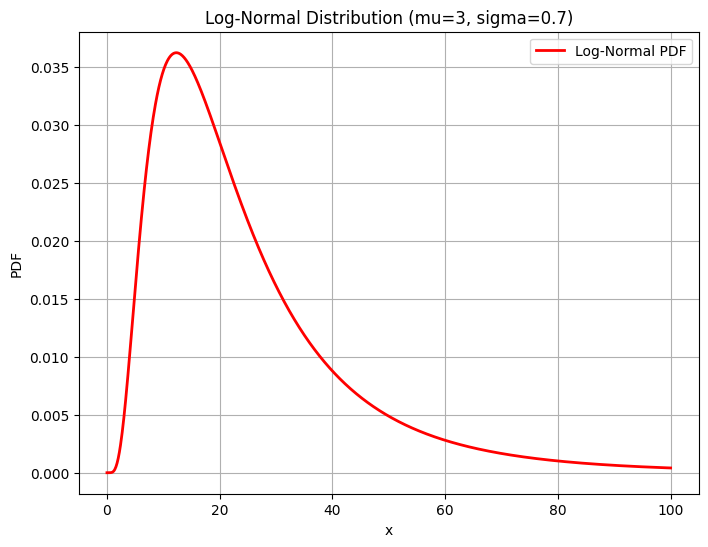

In [6]:
mu = 3

sigma = 0.7


x = np.linspace(0, 100, 1000)

pdf = lognorm.pdf(x, s=sigma, loc=0, scale=np.exp(mu))

plt.figure(figsize=(8, 6))
plt.plot(x, pdf, "r-", lw=2, label="Log-Normal PDF")
plt.title(f"Log-Normal Distribution (mu={mu}, sigma={sigma})")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)

plt.show()


In [36]:
def model(patch_id, c_trust, time, baseline_prior, trust_prior):
    # baseline = numpyro.sample("baseline", dist.Normal(*baseline_prior).expand([len(set(patch_id))]))
    # tr = numpyro.sample("tr", dist.Normal(*trust_prior).expand([len(set(patch_id))]))

    baseline = numpyro.sample("baseline", dist.Uniform(*baseline_prior).expand([len(set(patch_id))]))
    tr = numpyro.sample("tr", dist.Uniform(*trust_prior).expand([len(set(patch_id))]))
    sigma = numpyro.sample("sigma", dist.LogNormal(3, 0.7))
    mu = baseline[patch_id] + tr[patch_id] * c_trust
    numpyro.sample("time", dist.Normal(mu, sigma), obs=time)


def get_samples(data, baseline_prior, trust_prior):
    data["patch_id"] = data.reward_patch_dim.astype("category").cat.codes
    data["time"] = data["time to first food"]

    guide = AutoLaplaceApproximation(model)
    svi = SVI(
        model,
        guide,
        optim.Adam(1),
        Trace_ELBO(),
        patch_id=data.patch_id.values,
        c_trust=data.c_trust.values,
        time=data.time.values,
        baseline_prior=baseline_prior,
        trust_prior=trust_prior,
    )
    svi_result = svi.run(random.PRNGKey(0), 3000)
    params = svi_result.params
    post_svi = guide.sample_posterior(random.PRNGKey(1), params, (2000,))

    return {"post_svi": post_svi}

In [37]:
post30high = get_samples(impactDF_grid30_high, baseline_prior=(10, 30), trust_prior=(0, 20))

NameError: name 'num_patches' is not defined

In [27]:
post30low = get_samples(impactDF_grid30_low, baseline_prior=(10, 30), trust_prior=(0, 20))

100%|██████████| 3000/3000 [00:01<00:00, 2589.81it/s, init loss: 307379.3750, avg. loss [2851-3000]: 1504.1935]


In [28]:
post45 = get_samples(impactDF_grid45, baseline_prior=(20, 30), trust_prior=(0, 10))

100%|██████████| 3000/3000 [00:01<00:00, 2437.13it/s, init loss: 1599569.7500, avg. loss [2851-3000]: 2187.5798]


In [29]:
post45high = get_samples(impactDF_grid45_high, baseline_prior=(20, 30), trust_prior=(0, 10))

100%|██████████| 3000/3000 [00:01<00:00, 2771.09it/s, init loss: 671020.0625, avg. loss [2851-3000]: 1025.4948]


In [30]:
post45low = get_samples(impactDF_grid45_low, baseline_prior=(20, 30), trust_prior=(0, 10))

100%|██████████| 3000/3000 [00:01<00:00, 2607.97it/s, init loss: 928583.3750, avg. loss [2851-3000]: 1158.1488]


In [31]:
def plot_coefs(post, group, grid_size=30):
    df_svi = pd.DataFrame(
        post["post_svi"]["tr"], columns=["patch 1", "patch 2", "patch 4"]
    )

    fig_svi = px.histogram(
        df_svi,
        x=["patch 1", "patch 2", "patch 4"],
        nbins=90,
        template="plotly_dark",
        title=f"Posterior coefficients of trust (SVI, {group}, grid {grid_size})",
        opacity=0.5,
    )

    fig_svi.update_layout(
        xaxis_title="coefficient of trust",
        yaxis_title="",
        legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.9),
        yaxis=dict(showgrid=False),
    )

    fig_svi.show()


In [32]:
plot_coefs(post30high, ">0.3", 30)

In [33]:
plot_coefs(post30low, "<0.3", 30)

In [34]:
plot_coefs(post45high, ">0.3", 45)


In [35]:
plot_coefs(post45low, "<0.3", 45)
